# Module 5 - Bias in Word Embeddings

### Assignment overview

In this assignment, you will be asked to evaluate gender bias in word embeddings, debias the embeddings in post-processing, and determine the extent to which the bias is still present after debiasing.

The assignment is modeled after “Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases in Word Embeddings But do not Remove Them, by Hila Gonen and Yoav Goldberg (https://arxiv.org/pdf/1903.03862.pdf). 

For this assignment, it is possible to work in **groups of up to 2 students**. 

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Yanxin Liang 50798412
- Student 2: Yelia Ye 89657605


### Learning Goals:

After completing this assignment, you will be able to:
1. Evaluate the extent of language bias in word embeddings (pre-trained or trained on a new corpus of text) 
2. Apply a post-processing approach to reduce the presence of stereotypes in word embeddings; recognize and explain their limitations 
3. Evaluate the presence of bias in word embeddings after the application of de-biasing strategies 


## 1. Introduction to NLP and Word Embeddings 

Natural language processing, or NLP for short, is the study of how to use computers in order to process, analyze, and produce language similar to how a human would. You've come across NLP if you've used:

- Google Translate
- Speech to text tools
- And of course, ChatGPT...

The question is: how do we go from words in a language to something a computer can understand? One of the answers is word embeddings. Word embeddings are a way to represent a word using a vector of numbers, in a way such that similar words will have vectors that are closer to each other. For example, when we convert the word "bad" into a word embedding, we would expect it to be close to the embedding for "worst", but maybe not as close to the word "rainbow".

<center>
<img src="wordEmbeddings.png" width="500"/>
</center>

There are many different pre-trained word embeddings out there, trained on different kinds of data. In this module we will use pre-trained embeddings (no need to create our own). Before we do that, let's get some more familiarity with vectors and their operations...

### Vectors and Vector Arithmetic

To better understand word embeddings, we first need to know how these words are represented - vectors - and what operations can be applied to them. A vector is a type of data that has a magnitude and direction. Vectors can exist in spaces of any dimension. For example, $\vec{[1, 2]}$ is a vector in 2D space, and $\vec{[4, 1, 7]}$ is a vector in 3D space. Let's work in 2D space, to make it easier to visualize. 

Suppose we have two vectors:
    
$a = \vec{[1, 2]}$

$b = \vec{[-3, 1]}$

Let's start by plotting $a$ in red and $b$ in blue.

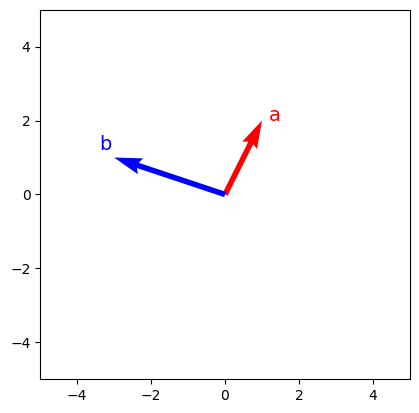

In [1]:
import numpy as np
import matplotlib.pyplot as plt

a = np.array([1, 2]) # vector a
b = np.array([-3, 1]) # vector b
origin = np.array([[0, 0],[0, 0]]) # origin point

# plotting
V = np.array([a, b])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'], angles='xy', scale_units='xy', scale=1, width=0.015)
plt.text(V[0,0] + 0.2, V[0,1], 'a', fontsize=14, color='red')
plt.text(V[1,0] - 0.4, V[1,1] + 0.2, 'b', fontsize=14, color='blue')
plt.xlim((-5,5))
plt.ylim((-5,5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

Now, we will try adding $a$ and $b$. To do this, all we have to do is sum the first coordinate of $a$ with the first coordinate of $b$, and the second coordinate of $a$ with the second coordinate of $b$. 

We get $1 + (-3) = -2$ for the first coordinate, and $2 + 1 = 3$ for the second coordinate. So, $a + b = \vec{[-2, 3]}$.


But this has more than just an abstract meaning. It makes sense when you think about it in terms of geometry too. In geometrical terms, going in the direction of $a + b$ means going in the direction of $a$ for $a$'s magnitude, then the direction of $b$ for $b$'s magnitude. Let's see what it looks like, in green.

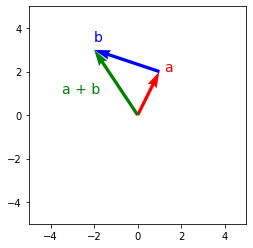

In [2]:
origin = np.array([[0, 1, 0],[0, 2, 0]]) # origin point; for b, the origin is now the
                                         # tip of a (1,2)

V = np.array([a, b, a + b])
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], angles='xy', scale_units='xy', scale=1, width=0.015)
plt.text(V[0,0] + 0.2, V[0,1], 'a', fontsize=14, color='red')
plt.text(V[1,0] + 1, V[1,1] + 2.4, 'b', fontsize=14, color='blue')
plt.text(V[2,0] - 1.5, V[2,1] - 2, 'a + b', fontsize=14, color='green')
plt.xlim((-5,5))
plt.ylim((-5,5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

Now that we have a taste for vector addition, let's try some vector subtraction. To find $a - b$, we subtract the first coordinate of $b$ from the first coordinate of $a$, and the second coordinate of $b$ from the second coordinate of $a$. 

We get $1 - (-3) = 4$ for the first coordinate, and $2 - 1 = 1$ for the second coordinate. So $a - b = \vec{[4, 1]}$. 

In geometrical terms, going in the direction of $a - b$ means going in the direction of $a$ for $a$'s magnitude, then the OPPOSITE direction of $b$ for $b$'s magnitude. Let's see what it looks like, in green.

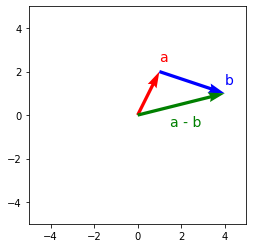

In [3]:
origin = np.array([[0, 1, 0],[0, 2, 0]]) # origin point; again, for b, the origin is now the
                                         # tip of a (1,2)

V = np.array([a, -b, a - b]) # -b means we inverted its direction
plt.quiver(*origin, V[:,0], V[:,1], color=['r','b', 'g'], angles='xy', scale_units='xy', scale=1, width=0.015)
plt.text(V[0,0], V[0,1] + 0.5, 'a', fontsize=14, color='red')
plt.text(V[1,0] + 1, V[1,1] + 2.4, 'b', fontsize=14, color='blue')
plt.text(V[2,0]- 2.5, V[2,1] - 1.5, 'a - b', fontsize=14, color='green')
plt.xlim((-5,5))
plt.ylim((-5,5))
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

Finally, we'll talk about the dot product. The dot product of two vectors is a measure for how similar of a direction they are pointing in. The dot product of $a$ with $b$ shows us the amount that $a$ is pointing in the same direction as $b$. To calculate the dot product, multiply each coordinate of $a$ with its corresponding coordinate of $b$, then add everything together. 

$a \cdot b = 1(-3) + 2(1) = -1$

In geometrical terms, if the dot product is a **positive number**, the vectors form an acute angle with one another (they are pointing in **similar directions**). If the dot product is a **negative number**, the vectors form an obtuse angle with one another (they are pointing in **opposite directions**). And if the dot product is 0, the vectors form a right angle with one another (they are pointing in perpendicular directions). So it makes sense that the dot product of $a$ and $b$ is negative because the angle between them is obtuse.

### Question 1
Your turn! Complete the following operations on these vectors, which now have three dimensions.

$a = \vec{[3, 1, 2]}$ 

$b = \vec{[-1, 2, 1]}$

- What is $a + b$?
- What is $a - b$?
- What is $a \cdot b$? Are they pointing in the same or in the opposite direction?

For $a+b$, we get $3 + (-1) = 2$ for the first coordinate, $1 + 2 = 3$ for the second coordinate, and $2 + 1 = 3$ for the third coordinate. So, $a + b = \vec{[2, 3, 3]}$.

For $a-b$, We get $3 - (-1) = 4$ for the first coordinate, $1 - 2 = -1$ for the second coordinate, and $2 - 1 = 1$ for the third coordinate. So, $a - b = \vec{[4, -1, 1]}$.

For $a \cdot b$, We get dot product $3 * (-1) + 1 * 2 + 2 * 1 = 1$. So, $a \cdot b = 1$. Since the dot product is 1 which is positive, the vectors point in the same direction.

### Load GloVe Embeddings

We are now ready to start working with some word embeddings. As mentioned before, we will work with pre-trained model. For this portion of the exercise, we will work with GloVe, pre-trained on Wikipedia.

In [3]:
# You will need to run this cell once to install the new package. After that, comment out the command
# !pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 5.5 MB/s eta 0:00:0000:0100:01


In [4]:
import gensim
from gensim import models
import gensim.downloader as api

In [5]:
# This may take a couple minutes to load.
model = api.load("glove-wiki-gigaword-100")

# Disclaimer: glove-wiki-gigaword-100 is a pre-trained model of 400000 records, trained on Wikipedia. It is
# much smaller than models used for real applications, and as such it will not always behave one
# would expect.

### Similarities and Analogies

In [6]:
# A list of words - you can try others if you'd like!
lst = ['librarian', 'cash', 'president', 'exercise', 'dog']

Look how easy it is to find similar words using word embeddings - all we have to do is look for the next nearest vectors! And the GloVe API has a function to do this - let's try it out:

In [7]:
for word in lst: 
    similar_words = model.most_similar(word) # getting the most similar word using GloVe API
                                             # by default, it returns the 10 closest words
    similar_words = [w[0] for w in similar_words]
    print(f"Similar words for '{word}': {', '.join(similar_words)}")

Similar words for 'librarian': archivist, lecturer, clerk, tutor, curator, educator, adjunct, teacher, library, chaplain
Similar words for 'cash': money, funds, payment, credit, payments, loans, pay, amount, buy, debt
Similar words for 'president': vice, presidency, former, presidents, chairman, secretary, clinton, leader, government, met
Similar words for 'exercise': exercises, routine, training, practice, preparation, necessary, activities, exercising, regimen, take
Similar words for 'dog': cat, dogs, pet, puppy, horse, animal, pig, boy, cats, rabbit


Another great property of word embeddings is that analogies between words is represented as a simple vector operation. Look at these examples ([source](https://towardsdatascience.com/a-guide-to-word-embeddings-8a23817ab60f)):

<center>
<img src="vectorSimilarities.png" width="900"/>
</center>

Look at the plot on the left: the difference "man/woman" can be thought of as the distance between two vectors, and it should be the same for each pair of gendered words (man/woman, king/queen, actor/actress...). If I can compute this distance from a pair (for example, from the man/woman pair), I can apply it to another word ("king") and get to the other word in the pair ("queen"). This is true for any relationship between words (in the picture, gerund and past tense of a verb, and country and capital).

### Question 2

Given the vectors for the words $\vec{KING}$, $\vec{MAN}$ and $\vec{WOMAN}$, what operation (addition, subtraction, or a combination of) will lead me to the word $\vec{QUEEN}$?

$\vec{KING} - \vec{MAN} + \vec{WOMAN}$ will lead to the word $\vec{QUEEN}$.

We will now play around with analogies. Analogies are patterns of the form:

- Japan is to as Tokyo as India is to Delhi
- hand is to finger as foot is to toe

Word embeddings can help us "fill in the blank" for analogies, given just three of the words. The same GloVe function `most_similar()` can be given different parameters to compute analogies (see [documentation](https://rdrr.io/github/psychbruce/PsychWordVec/man/most_similar.html)). Knowing what we know so far about vectors and analogies, complete the definition of the `analogy()` function below:

In [12]:
def analogy(worda, wordb, wordc):
    result = model.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

# Uncomment when ready to try your function
analogy('japan', 'tokyo', 'india')

'delhi'

What about:

- man is to doctor as woman is to BLANK?

See for yourself:

In [13]:
# Use analogy() on this set of words

analogy('man', 'doctor', 'woman')

'nurse'

You just got a taste of bias in word embeddings...

### Quantifying Bias in Word Embeddings

Bias in word embeddings gets introduced through bias in the datasets the word embeddings are trained on, and this bias can go on to affect applications that the embeddings are used in. In this assignment, we are going to focus on gendered bias specifically. As our goal is to reduce the bias, we need a way to "measure" it, so we will now if our efforts have been successful or not. But how do we quantify gendered bias in word embeddings?

There is not a clearcut answer to this, but Bolukbasi et al. in their 2016 [paper](https://proceedings.neurips.cc/paper_files/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) on debiasing word embeddings recommend calculating the projection of each of the embeddings onto the "gender direction", which is the vector difference of the embedding for the word "he" and the embedding for the word "she". The greater the value of the projection, the more biased the embedding is. Negative projections indicate words more associated with women and positive projections indicate words more associated with men.

The picture below represents this concept (although the original he/she vectors are used, instead of their difference): if we look at other words in relation to the vectors "he" and "she", we will find that some are closer to "he", and therefore their projection along this vector is bigger ("doctor", in this example), while the opposite is true for female-gendered words (like "nurse"). Neutral words should have similar projections among both vectors.

<br>

<center>
<img src="biasEmbeddings.png" width="500"/>
</center>

#### A note on Sex and Gender

Sex and Gender have different meanings, despite often being used interchangeably. In humans, sex refers to a set of biological features such as chromosomes and gene expression. It is usually characterized as male or females, although intersex attributes are also possible. Gender refers to socially constructed roles, behaviours and identities, such as man, woman, or gender diverse. In this notebook, we use "man/woman" or "male-gendered/female-gendered" to emphasize the fact that biased word are more often associated with one of these genders than a biological sex. 

We will use another package for this portion of the exercise, called Natural Language Toolkit ([NLTK](https://www.nltk.org/)) - sorry, word embeddings are complex and some packages are better at some tasks than others...

In [14]:
import numpy as np
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to /Users/yeliaye/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


The code in the cell below does exactly what suggested by Bolukbasi - it takes the difference between the vectors "he" and "she" and computes the dot product of this vector with each word in the corpus, thus giving us a measure of how biased is that word.

**Note:** the original paper includes the normalization of all vectors so that the magnitude of a vector would not influence the measure of bias associated with it. It is, however, a rather lengthy process and, even though it would produce more accurate results, it is not strictly necessary for the purpose of this assignment. For us, it is sufficient to know that the projection of all vectors will have the right sign.

In [15]:
# For each word, we will store the projection in this dictionary
projections = {}

# He-she direction
he_she_direction = model['he'] - model['she']

# Dot product between every word and the he-she direction
for word in model.key_to_index:
    if word in words:
        proj_val = np.dot(model[word], he_she_direction)  # projection calculated as dot product
        projections[word] = proj_val

### Question 3

In `projections`, look up the word 'student'. What is its projection value? Does this indicate bias toward man or toward woman?

In [16]:
# Your solution here
np.dot(model['student'], he_she_direction)

-0.565183

A negative value -0.565 indicates that the word "student" is closer to the "she" embedding in the gender direction.

Here are the top 30 biased words for each gender, according to the method we described above. 

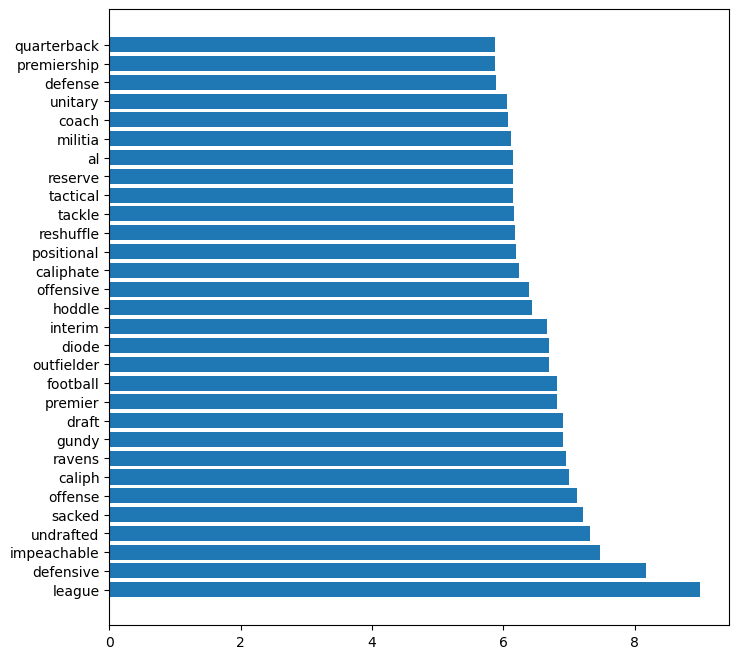

In [17]:
# Biased toward man

import matplotlib.pyplot as plt
proj_dict = dict(sorted(projections.items(), key=lambda x:x[1], reverse=True)[:30])
plt.figure(figsize=(8,8))
plt.barh(list(proj_dict.keys()), list(proj_dict.values()))
plt.show()

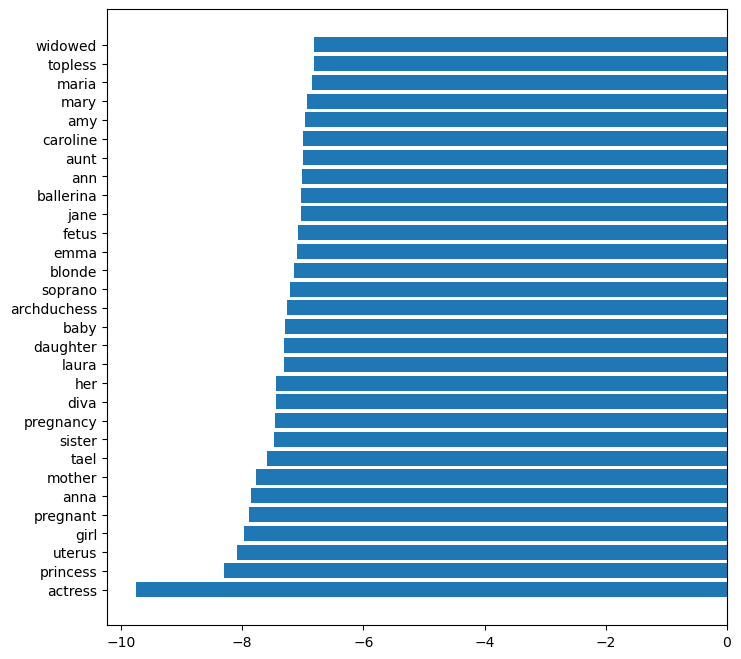

In [18]:
# Biased toward woman

proj_dict = dict(sorted(projections.items(), key=lambda x:-x[1], reverse=True)[:30])
plt.figure(figsize=(8,8))
plt.barh(list(proj_dict.keys()), list(proj_dict.values()))
plt.show()

### Question 4
Look carefully at the lists of words. Which words, if any, do you think should remain associated with a specific gender? Which words should not be?


Some words should stay linked to a specific gender because their meaning depends on it. For example, words like "king," "queen," "mother," "father," "brother," and "sister" are naturally tied to gender and should stay that way. The words like job titles, should not be connected to a specific gender, such as "doctor," "nurse," "engineer," should be neutral so they don’t support unfair stereotypes. It’s important to only keep gender links for words where it clearly makes sense, while making other words neutral to ensure fairness.

### Question 5

We can look at the distribution of projections as a histogram, to get a sense of the typical values. What gender are most words bias toward? If you think the histogram is not sufficiently clear, you may also compute the average bias in the projections dictionary.

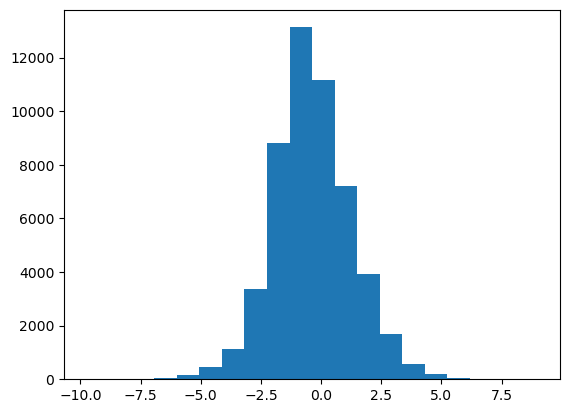

In [19]:
plt.hist(projections.values(), bins=20)
plt.show()

In [20]:
# the average bias
sum(projections.values()) / len(projections)

-0.36600614182264674

The calculated average bias is -0.366, which is a negative value, which means that the embeddings have an overall bias toward women.

### Question 6

Let's look at the most similar words to some words that appeared as highly biased (*ballerina, amy,* and *league*). Do you notice any word that surprises you, or that you think should not be there?

In [21]:
for word in ['ballerina', 'amy', 'league']: 
    similar_words = model.most_similar(word)
    similar_words = [w[0] for w in similar_words]
    print(f"Similar words for '{word}': {', '.join(similar_words)}")

Similar words for 'ballerina': dancer, ballerinas, ballet, bolshoi, pavlova, choreographer, ingenue, actresses, courtesan, dancers
Similar words for 'amy': jennifer, lisa, susan, alice, julie, judy, linda, jill, rachel, laura
Similar words for 'league': football, club, leagues, teams, team, season, soccer, baseball, seasons, champions


For the word "ballerina," similar words like "dancer" and "ballet" make sense, but words like "actresses" and "courtesan" seem surprising and reinforce gender stereotypes that may not be appropriate. For "amy," the similar words are all common female names like "jennifer" and "lisa," which shows a strong gender bias because it only connects the word to femininity and ignores more neutral or professional associations. On the other hand, the word "league" is linked to neutral and relevant words like "football," "soccer," and "club," which show no clear gender bias.

The next cell assigns a label to the 1000 most biased words in the dictionary: 1 for male-gendered and -1 female-gendered. These labels will be helpful to see if we can effectively remove the bias from the word embedding.

In [22]:
proj_dict = dict(sorted(projections.items(), key=lambda x:abs(x[1]), reverse=True)[:1000])
ground_truth_lst = [1 if proj_dict[k] >= 0 else -1 for k, v in proj_dict.items()]
ground_truth_dct = {k: 1 if proj_dict[k] >= 0 else -1 for k, v in proj_dict.items()}

### Question 7

We can use [Principal Component Analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis) to visualize the distributions of the 1000 most biased words in a two-dimensional space. 

The code below produces this plot. Do you think it would be easy for a clustering algorithm to separate the words into two clusters? Do you think these clusters correspond to the two groups of gendered words we are analyzing?

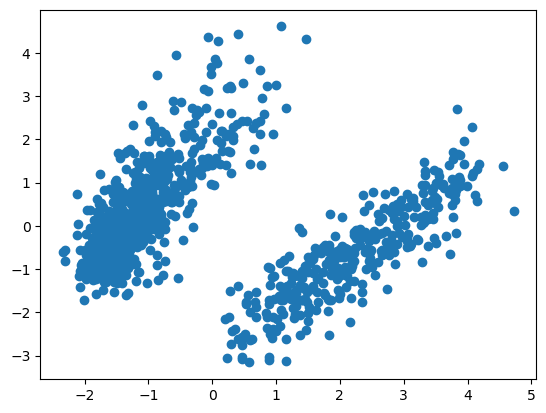

In [23]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df = pca.fit_transform([model[i] for i in proj_dict])

plt.scatter(df[:, 0] , df[:, 1])
plt.show()

The plot shows two clear groups of words, which means that the words can be easily separated into two clusters based on their gender bias. This suggests that male-associated words and female-associated words are very different in the embedding space. A clustering algorithm, like K-Means, would have no trouble separating these groups. This shows that the bias in the embeddings is strong enough to create a clear divide between male and female biased words.

Running the cell below, we can see that a simple clustering algorithm (K-Means) has no issue separating the two groups, and they correspond with the clusters we could observe after reducing dimensionality.

/opt/miniconda3/envs/dsci430/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


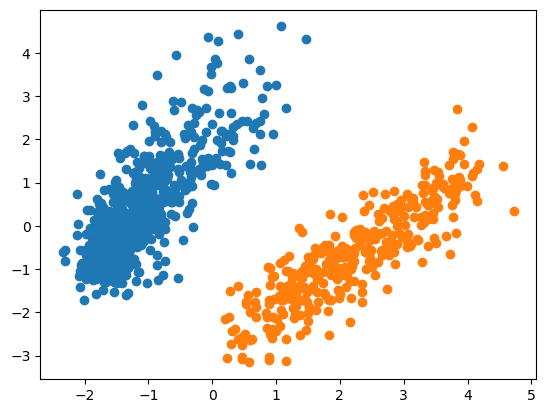

In [24]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
label = kmeans.fit_predict([model[i] for i in proj_dict])

for i in [0, 1]:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.show()

### Question 8

Let's see how well the clusters from K-Means match up with the bias labels we determined from the projections. Comment on the output of this cell. How well was K-Means able to create groups that match the original projections?

In [25]:
import statistics as stats

neg_cluster = stats.mode([label[idx] for idx, val in enumerate(ground_truth_lst) if val == -1])
pos_cluster = stats.mode([label[idx] for idx, val in enumerate(ground_truth_lst) if val == 1])

sum([1 for idx, val in enumerate(ground_truth_lst) if (val == 1 and label[idx] == pos_cluster) 
     or (val == -1 and label[idx] == neg_cluster)])/len(ground_truth_lst)

1.0

*Your answer here*

# Neutralize and Equalize

Now that we have a better idea of what it means for a word embedding to be biased, and we also have tools to quantify and visualize that bias, we are going to try to improve it. The code below attempts to mathematically remove the bias using the approach described in Bolukbasi's paper, by removing from the word's vector its projection along the he-she direction. Simply run the cells below to debias the word embedding.

In [26]:
# This cell excludes from debiasing words for which being gendered makes sense, such as "he"/"she", 
# "actor"/"actress", or "policeman"/"policewoman"

gender_specific_pairs = [["he", "she"], ["his", "hers"], ["him", "her"], ["man", "woman"], ["men", "women"], ["husband", "wife"], ["himself", "herself"], ["son", "daughter"], ["father", "mother"], ["uncle", "aunt"], ["guy", "gal"], ["boy", "girl"], ["king", "queen"], ["brother", "sister"], ["female", "male"], ["gentleman", "lady"], ["mom", "dad"], ["actor", "actress"], ["boyfriend", "girlfriend"], ["prince", "princess"], ["sir", "madam"], ["grandmother", "grandfather"]]

for i in model.key_to_index:
    if i in words and 'woman' == i[-5:]:
        man_version = i[:-5] + "man"
        if man_version in model.key_to_index:
            gender_specific_pairs.append([man_version, i])

In [27]:
# This function removes the component of a vector u that is in the direction of a vector v. 
# We will use it to remove the he-she projection from each word in the embedding.
def drop(u, v):
    return u - v * u.dot(v) / v.dot(v)

gsw = sum(gender_specific_pairs, [])

# Removing the gender component of words that are not gender-specific from the 1000 most biased words and normalizing
for w in proj_dict:
    if w not in gsw: # We only want to debias the words that are not gender-specific.
        model[w] = drop(model[w], he_she_direction) # Removing the gender component of the vector that represents the word w
        model[w] = model[w]/np.linalg.norm(model[w]) # Normalize the new vector (i.e., keep the direction but change length to 1)

# Shifting the vectors for words that are gender specific to make sure that 
# each non-gender-specific word is equidistant from both words in the gender-specific pair
for (a, b) in gender_specific_pairs:
    model[a] = model[a]/np.linalg.norm(model[a]) # Normalize vector for a
    model[b] = model[b]/np.linalg.norm(model[b]) # Normalize vector for b
    u = (model[a] + model[b]) / 2 # Find the vector that is exactly in between a and b
    y = drop(u, he_she_direction) # Remove the component from that vector that is in the gender direction
    z = np.sqrt(1 - np.linalg.norm(y)**2) 
    if (model[a] - model[b]).dot(he_she_direction) < 0:  
        z = -z
    model[a] = z * he_she_direction + y # Since the non gender specific words have their gender component removed now,  we are shifting 
    model[b] = -z * he_she_direction + y # the gendered words in relation to the gender component so they will be equidistant from the non-gendered words.

Following our debiasing strategy, all words (minus the excluded gendered words) are now equally distant from the vectors "he and "she". Observe this on the word "coach".

In [28]:
np.linalg.norm(model['he'] - model['coach'])

1.3031596

In [29]:
np.linalg.norm(model['she'] - model['coach'])

1.3031597

### Question 9

Let's again use PCA and plot the words after debiasing. Can you separate them into clusters now?

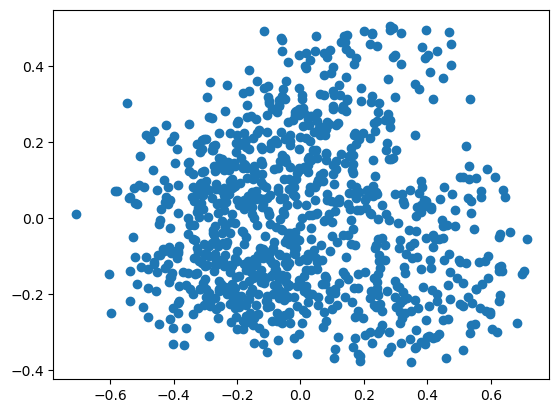

In [30]:
pca = PCA(n_components=2)
df = pca.fit_transform([model[i] for i in proj_dict if i not in gsw])

plt.scatter(df[:, 0] , df[:, 1])
plt.show()

*Your answer here*

In the plot below, you can observe K-Means' attempt to separate the words in two clusters (using the original high-dimensional space).

/opt/miniconda3/envs/dsci430/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


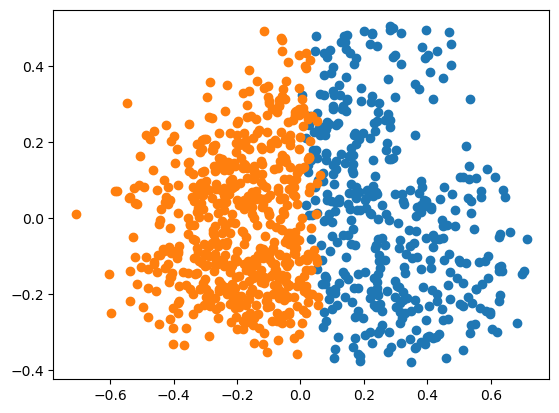

In [31]:
kmeans = KMeans(n_clusters=2)
label_debias = kmeans.fit_predict([model[i] for i in proj_dict if i not in gsw])

for i in [0, 1]:
    plt.scatter(df[label_debias == i , 0] , df[label_debias == i , 1] , label = i)
plt.show()

From the plot, it is not clear if K-Means was able to group the words by the original gendered labels. We can see that there are no obvious clusters, but does this mean the bias is gone? Let's check in the next cell...

### Question 10

1. Let's see how well the groups found by KMeans overlap with the original gendered labels. What percent of the words are clustered "correctly" according to the bias? What does this mean in terms of success of our debiasing efforts? 
2. Based on this results, would you say that looking at the plot of words in 2D is an effective way to estimate the presence of bias in a dataset?

In [32]:
ground_truth_not_gsw = [ground_truth_dct[k] for k in ground_truth_dct if k not in gsw]

neg_cluster = stats.mode([label_debias[idx] for idx, val in enumerate(ground_truth_not_gsw) if val == -1])
pos_cluster = stats.mode([label_debias[idx] for idx, val in enumerate(ground_truth_not_gsw) if val == 1])

sum([1 for idx, val in enumerate(ground_truth_not_gsw) if (val == 1 and label_debias[idx] == pos_cluster) 
     or (val == -1 and label_debias[idx] == neg_cluster)])/len(ground_truth_not_gsw)

0.7298969072164948

*Your answer here*

### Question 11

Let's review the similar words to *ballerina, amy,* and *league*, which were originally identified as highly biased. Do you see any change? Do you think this is an improvement?

In [33]:
for word in ['ballerina', 'amy', 'league']: 
    similar_words = model.most_similar(word)
    similar_words = [w[0] for w in similar_words]
    print(f"Similar words for '{word}': {', '.join(similar_words)}")

Similar words for 'ballerina': bolshoi, ballerinas, choreographer, balanchine, choreographers, prima, nureyev, flamenco, ballets, dancers
Similar words for 'amy': larry, greg, steve, scott, eric, david, michael, tom, anthony, james
Similar words for 'league': champions, soccer, leagues, season, teams, games, clubs, seasons, hockey, championship


*Your answer here*

## Debiasing during training

The method that we have worked through is a method to debias embeddings AFTER they have already been created. What if, instead, the training process itself encouraged producing embeddings with less bias? Zhao et al. describe a way to do this with GloVe, **altering the loss function of the model** to focus any gender specific information into the last coordinate of each vector. This way, the resulting vectors can be used without the last coordinate, removing the gender information. 

Here, we will load the GloVe embeddings debiased during training, and perform clustering to compare the difference between these and the hard debiased vectors that we produced in the last section.

In [4]:
import numpy as np
import pickle as pkl
f = open('gn_glove.vocab', 'r', encoding="utf-8")
vocab = [i.strip() for i in f.readlines()]
vecs = np.load('gn_glove.wv.npy')
gn_dct = {vocab[i]: vecs[i] for i in range(len(vecs))}

In [7]:
kmeans = KMeans(n_clusters=2)
proj_dict_subset = {k: v for k, v in proj_dict.items() if k in gn_dct}
label = kmeans.fit_predict([gn_dct[i] for i in proj_dict_subset])

pca = PCA(n_components=2)
df = pca.fit_transform([gn_dct[i] for i in proj_dict_subset])
 
for i in [0, 1]:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

NameError: name 'KMeans' is not defined

In [6]:
female_bias = [label[idx] for idx, i in enumerate(proj_dict_subset) if proj_dict_subset[i] < 0]
male_bias = [label[idx] for idx, i in enumerate(proj_dict_subset) if proj_dict_subset[i] > 0]

right_cluster = [1 for i in female_bias if i == stats.mode(female_bias)] + [1 for i in male_bias if i == stats.mode(male_bias)]
pct_clustered_by_gender = round(100*sum(right_cluster)/len(proj_dict_subset), 2)
print("With GloVe embeddings debiased during training, {} percent of terms are clustered according to gender.".format(pct_clustered_by_gender))

NameError: name 'proj_dict_subset' is not defined

### Question 12

Answer the following questions to test your understanding on bias in word embeddings:

1. What are the reasons that word embeddings can be biased? How do you think using different data sets to train embeddings might affect the type or amount of bias?
2. What are some real world applications that might be affected by the remaining bias in the embeddings?

*Your answer here*

# Bias in Large Language Models (LLMs)

Large Language Models (like ChatGPT) are deep neural networks trained on *very large* corpus of text to be able to produce human-like sentences. Their capabilities are impressive, but since they are typically trained on text found online, they can be rigged with all sorts of biases. Here are a couple of examples (source: https://medium.com/mlearning-ai/inherent-human-bias-in-chat-gpt-ed803d4038fe)

Bias based on nationality:
<br>
<br>
<center>
<img src="chatGPTnationBias.png" width="800"/>
</center>

Bias based on race and gender: 
<br>
<br>
<center>
<img src="chatGPTraceBias.png" width="800"/>
</center>

Here is another example of bias based on gender when making jokes, which I was able to generate on 2023/11/05:
<br>
<br>
<center>
<img src="jokeBias.png" width="800"/>
</center>

Developers behind these language models are constantly trying to eliminate the problem (as you can imagine, biased responses are not well received by the public). As far as we know (which is limited - many of these models are kept in secret) bias is prevented by better data curation, model fine-tuning, and more strict evaluation. In fairness, LLMs are becoming better and better at avoiding biased responses, but the problem still exists in some forms. 

### Question 13

A team at UC Berkeley developed a [tool](https://chat.lmsys.org/?utm_medium=email&utm_source=gamma&utm_campaign=-lmsys-2023) to allow people to test and evaluate LLMs models. You are going to use this tool to test different language models and "hunt" for persistent biases.

Do the following:
1. Go to https://chat.lmsys.org/?utm_medium=email&utm_source=gamma&utm_campaign=-lmsys-2023
2. Pick one option:
    - Under Arena (side-by-side), pick two models to compare (it can be a random choice) and enter a prompt - remember that your goal is to generate a biased answer. Observe the 2 answers: where you able to find bias in at least one of the models? Is a model more biased than the other?
    - Under Direct Chat, pick a model (it can be a random choice) and enter 2-3 prompts, each time changing the question to include a different population (like we saw in the lightbulb jokes example). Compare the answers: can you observe differences caused by the changes introduced in the question?
3. Report your findings here, **including your prompt, the names and the answers of both models (the names of the models are visible after their answers), and your evaluation.**

*Your answer here*